In [1]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load dữ liệu
data = pd.read_csv("../../../Dataset/AKAM_Stock.csv")
df=data.reset_index()['Close']

In [3]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# Chia train test
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [5]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [11]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [12]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [13]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=32, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:675: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Epoch 1, Loss: 0.1300097182393074
Epoch 2, Loss: 0.03975614073375861
Epoch 3, Loss: 0.03077037980159124
Epoch 4, Loss: 0.019440476782619953
Epoch 5, Loss: 0.009066110507895549
Epoch 6, Loss: 0.006642920834322771
Epoch 7, Loss: 0.0056565421012540655
Epoch 8, Loss: 0.004975496573994557
Epoch 9, Loss: 0.004585271359731754
Epoch 10, Loss: 0.00449343187113603
Epoch 11, Loss: 0.0043912051556011045
Epoch 12, Loss: 0.003971996530890465
Epoch 13, Loss: 0.0038609422898540895
Epoch 14, Loss: 0.0037433072769393525
Epoch 15, Loss: 0.003660997453456124
Epoch 16, Loss: 0.0035853308315078416
Epoch 17, Loss: 0.0033693729899823667
Epoch 18, Loss: 0.0032618624002983174
Epoch 19, Loss: 0.0033861113556971152
Epoch 20, Loss: 0.0030256692320108415
Epoch 21, Loss: 0.00325869827841719
Epoch 22, Loss: 0.0030922935189058383
Epoch 23, Loss: 0.0029996802875151235
Epoch 24, Loss: 0.003055018396116793
Epoch 25, Loss: 0.0028597640960166854
Epoch 26, Loss: 0.0029907115114231903
Epoch 27, Loss: 0.0029945098329335453
Ep

In [14]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [15]:
# Dự báo 30 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[ 92.13220945]
 [ 92.92040589]
 [ 93.94119144]
 [ 94.94194869]
 [ 95.87216226]
 [ 96.74368294]
 [ 97.58031111]
 [ 98.40214387]
 [ 99.22252992]
 [100.04920568]
 [100.88624493]
 [101.73553899]
 [102.59773007]
 [103.47264526]
 [104.35950827]
 [105.2569853 ]
 [106.16319913]
 [107.0757115 ]
 [107.99153722]
 [108.9071477 ]
 [109.81850623]
 [110.72109972]
 [111.6100199 ]
 [112.48004799]
 [113.32576758]
 [114.14169877]
 [114.92246046]
 [115.6629397 ]
 [116.3584611 ]
 [117.00495974]]


In [16]:
# Dự báo 60 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[ 92.13220945]
 [ 92.92040589]
 [ 93.94119144]
 [ 94.94194869]
 [ 95.87216226]
 [ 96.74368294]
 [ 97.58031111]
 [ 98.40214387]
 [ 99.22252992]
 [100.04920568]
 [100.88624493]
 [101.73553899]
 [102.59773007]
 [103.47264526]
 [104.35950827]
 [105.2569853 ]
 [106.16319913]
 [107.0757115 ]
 [107.99153722]
 [108.9071477 ]
 [109.81850623]
 [110.72109972]
 [111.6100199 ]
 [112.48004799]
 [113.32576758]
 [114.14169877]
 [114.92246046]
 [115.6629397 ]
 [116.3584611 ]
 [117.00495974]
 [117.59912931]
 [118.13854566]
 [118.62177266]
 [119.048401  ]
 [119.41904817]
 [119.73533028]
 [119.99975615]
 [120.21562855]
 [120.38686775]
 [120.51787037]
 [120.61332593]
 [120.67804743]
 [120.71681257]
 [120.73425089]
 [120.73468138]
 [120.72209135]
 [120.70002352]
 [120.67157598]
 [120.63936344]
 [120.60553479]
 [120.57181554]
 [120.53951125]
 [120.50956759]
 [120.48261971]
 [120.45903458]
 [120.43894981]
 [120.4223513 ]
 [120.4090732 ]
 [120.39886497]
 [120.39141258]]


In [17]:
# Dự báo 90 ngày tiếp theo
x_input = X_test[-1].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

Dự báo 90 ngày tiếp theo:
[[ 92.13220945]
 [ 92.92040589]
 [ 93.94119144]
 [ 94.94194869]
 [ 95.87216226]
 [ 96.74368294]
 [ 97.58031111]
 [ 98.40214387]
 [ 99.22252992]
 [100.04920568]
 [100.88624493]
 [101.73553899]
 [102.59773007]
 [103.47264526]
 [104.35950827]
 [105.2569853 ]
 [106.16319913]
 [107.0757115 ]
 [107.99153722]
 [108.9071477 ]
 [109.81850623]
 [110.72109972]
 [111.6100199 ]
 [112.48004799]
 [113.32576758]
 [114.14169877]
 [114.92246046]
 [115.6629397 ]
 [116.3584611 ]
 [117.00495974]
 [117.59912931]
 [118.13854566]
 [118.62177266]
 [119.048401  ]
 [119.41904817]
 [119.73533028]
 [119.99975615]
 [120.21562855]
 [120.38686775]
 [120.51787037]
 [120.61332593]
 [120.67804743]
 [120.71681257]
 [120.73425089]
 [120.73468138]
 [120.72209135]
 [120.70002352]
 [120.67157598]
 [120.63936344]
 [120.60553479]
 [120.57181554]
 [120.53951125]
 [120.50956759]
 [120.48261971]
 [120.45903458]
 [120.43894981]
 [120.4223513 ]
 [120.4090732 ]
 [120.39886497]
 [120.39141258]
 [120.38636316

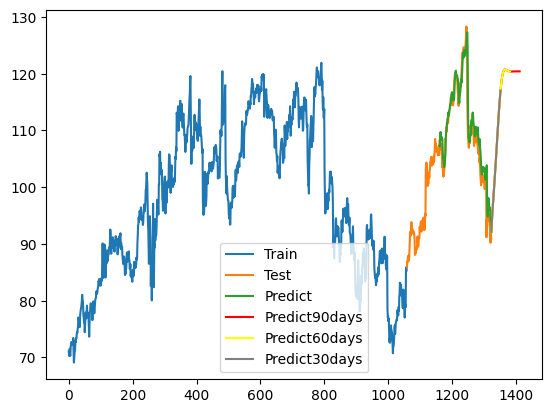

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(predictions))
predict_data_index_90 = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
predict_data_index_60 = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
predict_data_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

In [19]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 110.43544279994127
Testing MAPE: 16590.684169620523
Testing MAE: 110.16866030491371
